In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Point

In [23]:
years = [2008, 2009, 2012, 2016, 2019, 2020]
rap_codes = ['AFG', 'BGR', 'LTR', 'PFG', 'SHR', 'TRE']
metrics = ['cover_1-to-2m', 'cover_2-to-5m', 'cover_5m-plus']
terrain_features = ['elevation',
                   'hli',
                   'slope', 
                   'tpi_30',
                   'tpi_60',
                   'tpi_120',
                   'tpi_240',
                   'tpi_480',
                   'tpi_960',
                   'tpi_1920',
                   'twi']

lidar_bounds_path = 'data/vector/yearly_fold_assignments/{YEAR}.geojson'
metrics_path = 'data/raster/lidar_processed/canopy_metrics/{METRIC}/{YEAR}.tif'
terrain_path = 'data/raster/terrain/{FEATURE}.tif'
rap_path = 'data/raster/rap/{YEAR}.tif'

In [24]:
def make_grid(geojson_path):
    # Load the geojson as a geodataframe
    gdf = gpd.read_file(geojson_path)
    
    # Get bounds of the geodataframe
    minx, miny, maxx, maxy = gdf.total_bounds
    
    # Create grid points with 30m spacing
    x_coords = np.arange(minx, maxx, 30)
    y_coords = np.arange(miny, maxy, 30)
    
    # Create a mesh grid of points
    xx, yy = np.meshgrid(x_coords, y_coords)
    
    # Create points from the mesh grid
    points = gpd.GeoDataFrame(
        geometry=[Point(x, y) for x, y in zip(xx.flatten(), yy.flatten())],
        crs=gdf.crs
    )
    
    # Filter to only points within the polygons
    points_within = points[points.geometry.within(gdf.unary_union)]
    
    # Extract x and y coordinates of filtered points
    x_coords = points_within.geometry.x.values
    y_coords = points_within.geometry.y.values
    
    return x_coords, y_coords

def calc_lag_years(init_year):
    lag_0 = int(init_year)
    lag_1 = lag_0 - 1
    lag_2 = lag_1 - 1
    return [str(lag_0), str(lag_1), str(lag_2)]



In [25]:
dfs = []

for yr in years:
    # Get grid coordinates first
    xs, ys = make_grid(lidar_bounds_path.format(YEAR=yr))
    
    rap_lag_years = calc_lag_years(yr)
    print(rap_lag_years)

    # Initialize df with all columns as lists of the same length
    df = {
        'year': [yr] * len(xs),
        'x': xs,
        'y': ys
    }

    for yr_idx, rap_yr in enumerate(rap_lag_years):
        raster = rasterio.open(rap_path.format(YEAR=rap_yr))
        # Read all bands at once for the sampled points
        values = list(raster.sample(list(zip(xs, ys))))
        
        # Efficiently assign all bands to dataframe
        for feat_idx, feat in enumerate(rap_codes):
            feat_name = f'lag_{yr_idx}_{feat}'
            df[feat_name] = [val[feat_idx] for val in values]

    # Add each canopy metric as a new column in the dictionary
    for metric in metrics:
        raster = rasterio.open(metrics_path.format(METRIC=metric, YEAR=yr))
        values = [val[0] for val in raster.sample(list(zip(xs, ys)))]
        df[metric] = values
    
    for feature in terrain_features:
        raster = rasterio.open(terrain_path.format(FEATURE=feature))
        values = [val[0] for val in raster.sample(list(zip(xs, ys)))]
        df[feature] = values
    
    # Convert dictionary to dataframe and append to list
    dfs.append(pd.DataFrame(df))


data = pd.concat(dfs)


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_89108/1045541822.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within = points[points.geometry.within(gdf.unary_union)]


['2008', '2007', '2006']


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_89108/1045541822.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within = points[points.geometry.within(gdf.unary_union)]


['2009', '2008', '2007']


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_89108/1045541822.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within = points[points.geometry.within(gdf.unary_union)]


['2012', '2011', '2010']


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_89108/1045541822.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within = points[points.geometry.within(gdf.unary_union)]


['2016', '2015', '2014']


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_89108/1045541822.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within = points[points.geometry.within(gdf.unary_union)]


['2019', '2018', '2017']


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_89108/1045541822.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within = points[points.geometry.within(gdf.unary_union)]


['2020', '2019', '2018']


In [26]:
data.head()

,year,x,y,lag_0_AFG,lag_0_BGR,lag_0_LTR,lag_0_PFG,lag_0_SHR,lag_0_TRE,lag_1_AFG,...,hli,slope,tpi_30,tpi_60,tpi_120,tpi_240,tpi_480,tpi_960,tpi_1920,twi
0,2008,258837.689635,259828.732219,11,3,15,58,6,1,17,...,0.874569,0.356291,1.603882,4.753784,4.148193,-1.470093,-11.100464,-12.336670,-5.963135,0.988392
1,2008,258867.689635,259828.732219,11,4,17,54,7,1,15,...,0.878048,0.334665,2.194458,6.627686,12.104614,5.567993,-2.701172,-3.747559,2.392578,1.749427
2,2008,258897.689635,259828.732219,13,4,20,50,8,1,15,...,0.857420,0.232377,3.656982,9.685669,17.495483,11.958496,5.201782,4.289307,10.161377,1.441160
3,2008,258927.689635,259828.732219,13,6,23,47,6,0,13,...,0.810817,0.140330,2.746704,9.295776,15.232910,12.478394,7.157715,6.373901,11.948975,1.957156
4,2008,258957.689635,259828.732219,18,8,22,37,7,0,11,...,0.717921,0.391936,2.318726,4.536865,7.994873,8.333618,4.117920,3.499268,8.769775,0.883531


Text(0.5, 1.0, 'Sample Points by Year')

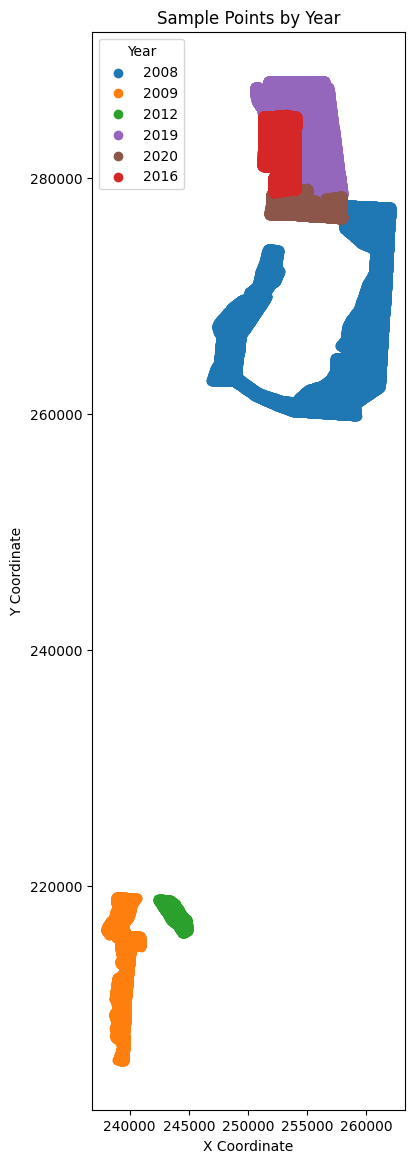

In [ ]:
# Create categorical colormap for the specific years
year_colors = {
    2008: '#1f77b4',  # blue
    2009: '#ff7f0e',  # orange 
    2012: '#2ca02c',  # green
    2016: '#d62728',  # red
    2019: '#9467bd',  # purple
    2020: '#8c564b'   # brown
}

plt.figure(figsize=(20,14))

# Plot non-2016 years first
for year in sorted([y for y in year_colors.keys() if y != 2016]):
    mask = data['year'] == year
    plt.scatter(data.loc[mask, 'x'], 
               data.loc[mask, 'y'],
               c=year_colors[year],
               label=str(year))

# Plot 2016 last so it appears on top
mask = data['year'] == 2016
plt.scatter(data.loc[mask, 'x'],
           data.loc[mask, 'y'], 
           c=year_colors[2016],
           label='2016')

# Set aspect ratio to 1:1
plt.gca().set_aspect('equal')

plt.legend(title='Year')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sample Points by Year')

In [37]:
# Split data into train and test sets based on year
train_data = data[data['year'] != 2020]
test_data = data[data['year'] == 2020]

print(f"Training set size: {len(train_data)} samples")
print(f"Test set size: {len(test_data)} samples")

train_data.to_csv('data/tabular/train.csv', index=False)
test_data.to_csv('data/tabular/test.csv', index=False)

Training set size: 186901 samples
Test set size: 12540 samples
